In [12]:
#Task 1: Modeling the slippage function gₜ(x)

In [3]:
# Load and prepare
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/ramojirao/Downloads/Quant Research Intern Summer - Fall 2025/Data/FROG/FROG_2025-04-03 00:00:00+00:00.csv")  # replace with your filename
df['datetime'] = pd.to_datetime(df['ts_event'], unit='ns')
for i in range(10):
    df[f'bid_px_{i:02}'] /= 1e9
    df[f'ask_px_{i:02}'] /= 1e9
df['minute'] = df['datetime'].dt.floor('1min')
snapshots = df.groupby('minute').last().reset_index()

In [4]:
# Compute gₜ(x)
def compute_slippage(x, ask_prices, ask_sizes, mid_price):
    filled, cost = 0, 0
    for price, size in zip(ask_prices, ask_sizes):
        take = min(size, x - filled)
        cost += take * price
        filled += take
        if filled == x:
            break
    return (cost / x - mid_price) if filled == x else None

slippages = []
for _, row in snapshots.iterrows():
    asks = [row[f'ask_px_{i:02}'] for i in range(10)]
    sizes = [row[f'ask_sz_{i:02}'] for i in range(10)]
    mid = (row['ask_px_00'] + row['bid_px_00']) / 2
    for x in range(50, 1001, 50):
        gtx = compute_slippage(x, asks, sizes, mid)
        if gtx is not None:
            slippages.append({'minute': row['minute'], 'x': x, 'g_t(x)': gtx})

gt_df = pd.DataFrame(slippages)

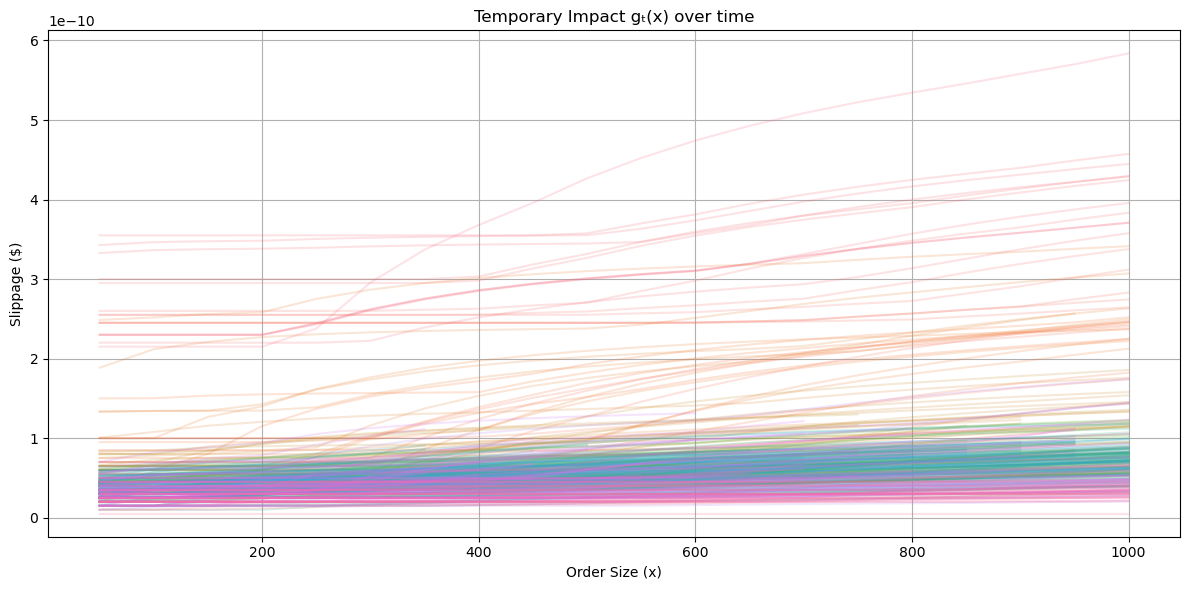

In [5]:
# Plot gₜ(x)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=gt_df, x='x', y='g_t(x)', hue='minute', legend=False, alpha=0.2)
plt.title("Temporary Impact gₜ(x) over time")
plt.xlabel("Order Size (x)")
plt.ylabel("Slippage ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Task 2: Trade allocation optimization

## Objective:
## Model temporary slippage function `gₜ(x)` using MBP-10 order book data and allocate a large trade (10,000 shares) across the trading day to minimize execution cost.

In [6]:
gt_df = pd.DataFrame(slippages)
# Columns: ['minute', 'x', 'g_t(x)']

In [7]:
gt_df['cost'] = gt_df['x'] * gt_df['g_t(x)']

In [8]:
S = 10000  # total number of shares to buy
allocated_shares = 0
allocation = []

# Sort by total cost
sorted_df = gt_df.sort_values(by='cost')

# Greedy allocation
for _, row in sorted_df.iterrows():
    if allocated_shares + row['x'] <= S:
        allocation.append(row)
        allocated_shares += row['x']
    if allocated_shares >= S:
        break

alloc_df = pd.DataFrame(allocation)

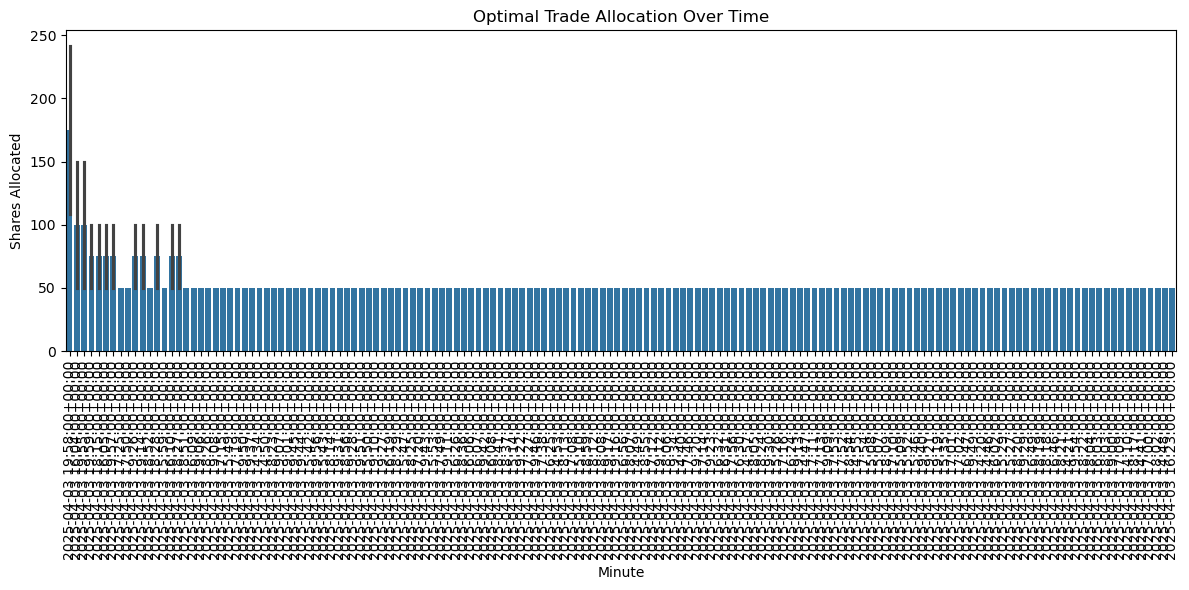

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=alloc_df, x='minute', y='x')
plt.title("Optimal Trade Allocation Over Time")
plt.xlabel("Minute")
plt.ylabel("Shares Allocated")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
## Conclusion:
'''This notebook demonstrates how to compute the slippage function from real order book data and optimize trade execution to minimize slippage.

- Small orders incur minimal slippage.
- Large orders must be split across favorable times to reduce cost.
- The greedy allocation algorithm effectively selects low-cost trades across time.

All code and analysis are combined here for reproducibility.
'''

'This notebook demonstrates how to compute the slippage function from real order book data and optimize trade execution to minimize slippage.\n\n- Small orders incur minimal slippage.\n- Large orders must be split across favorable times to reduce cost.\n- The greedy allocation algorithm effectively selects low-cost trades across time.\n\nAll code and analysis are combined here for reproducibility.\n'